### Part 1
-Getting data and visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 3)

In [2]:
file = 'https://github.com/iksinc/Data/raw/main/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file)

In [3]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [12]:
# Count the stroke/no-stroke cases
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [4]:
# Check for missing data
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# Before we look for filling in of missing values, we are going to understand/visualize the data
# But first, let's encode the categorical features
## First convert categorical variables
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])
df[0:2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,51676,1,61.0,0,0,0,1,1,202.21,NaN,1,1


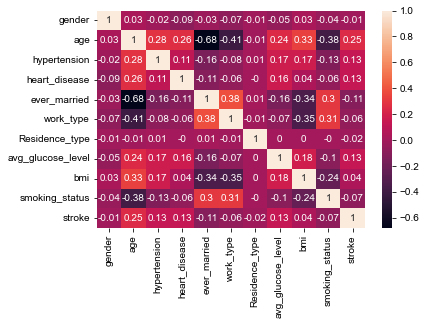

In [6]:
import seaborn as sns
corr = df.loc[:, df.columns != 'id'].corr() # Exclude id column in correlation computation
sns.heatmap(corr.round(2),annot=True)
sns.set(rc={"figure.figsize":(8, 8)})
plt.show()

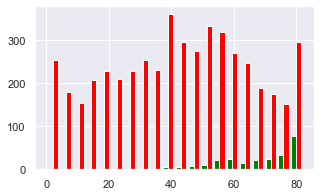

In [32]:
# Let's look at the plots of 'age','avg_glucose_level','bmi' for the two target values
plt.rc('figure', figsize=(5, 3))
plt.hist([df[df['stroke'] == 1]['age'],df[df['stroke'] == 0]['age']],color=['green', 'red'], bins=20);

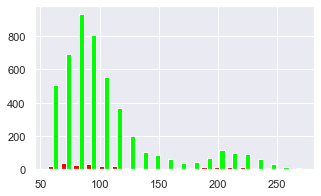

In [33]:
plt.hist([df[df['stroke'] == 1]['avg_glucose_level'],df[df['stroke'] == 0]['avg_glucose_level']],color=['red', 'lime'], bins=20);

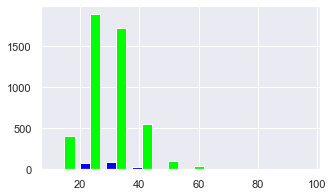

In [34]:
plt.hist([df[df['stroke'] == 1]['bmi'],df[df['stroke'] == 0]['bmi']],color=['blue', 'lime'], bins=10);

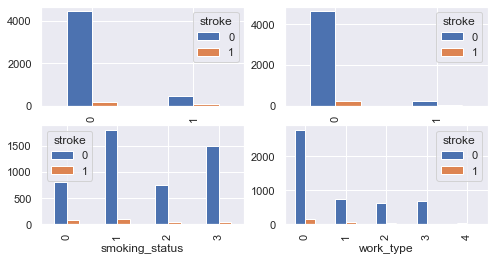

In [37]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2,figsize=(8, 4))
ax0 = df.groupby(['hypertension'])['stroke'].value_counts().unstack().plot(kind='bar',ax=ax0,stacked = False)
ax1 = df.groupby(['heart_disease'])['stroke'].value_counts().unstack().plot(kind='bar',ax=ax1,stacked = False)
ax2 = df.groupby(['smoking_status'])['stroke'].value_counts().unstack().plot(kind='bar',ax=ax2,stacked = False)
ax3 = df.groupby(['work_type'])['stroke'].value_counts().unstack().plot(kind='bar',ax=ax3,stacked = False)

### From above, we derive the following insight into the data
- Age has the highest correlation (0.25) with stroke
- BMI has similar level of correlation with age (+ corr), ever_married (- corr), and work_type(- corr)

### Part 2
- We will now fill-in the missing BMI values. 
- We will calculate the missing values by doing KNN regression on BMI with k=3.
- We will use KNN imputer for this purpose

In [38]:
from sklearn.impute import KNNImputer
X = df[['age','bmi']].copy()
imputer = KNNImputer(n_neighbors=3)
X =imputer.fit_transform(X)

In [39]:
print(np.isnan(X).sum())# Check if all missing values have been filled.

0


In [40]:
#Replace missing values in the dataframe
df['bmi']=X[:,1]

### Part 3
- We will use the logistic regression for our model
- We will first build the model without normalization/scaling
- Next, we will do the same with scaling and compare the two models

In [41]:
#Now we can start building our model
random_state=42
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [47]:
lrm = LogisticRegression(max_iter=200)
lrm.fit(X_train,y_train)
print(cross_val_score(lrm,X_test,y_test, cv=10).mean())

0.9549910873440286


In [48]:
# This looks too good considering we have a highly unbalanced dataset
# Let's look at the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(lrm.predict(X_test), y_test))

[[1464   69]
 [   0    0]]


In [ ]:
# Obvisouly, the model hasn't learned to differentiate between stroke/no-stroke
# This is because of the class imbalance in the data
# We can use the class weighting scheme to tell the model to give importance to y_train=1 examples
# We do this by balancing the class weights parameter

In [49]:
lrm = LogisticRegression(max_iter=200,class_weight='balanced')
lrm.fit(X_train,y_train)
print(cross_val_score(lrm,X_test,y_test, cv=10).mean())

0.763857057974705


In [50]:
print(metrics.confusion_matrix(lrm.predict(X_test), y_test))

[[1076   12]
 [ 388   57]]


In [ ]:
# Now we see that 82.6% of the stroke examples are being correctly classified.
# Changing the class_weight setting has been good.
# Next, let's see if the normalization will help.

In [54]:
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [57]:
lrm.fit(X_scaled,y_train)
print(cross_val_score(lrm,X_scaled,y_train, cv=10).mean())
X_test_scaled = scaler.transform(X_test)
print(cross_val_score(lrm,X_test_scaled,y_test, cv=10).mean())

0.7274290721875343
0.7645106527459469


In [58]:
# The results indicate that scaling doesn't change the results and thus can be omitted, if desired
# We will now generate the classification report.
y_pred = lrm.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1464
           1       0.13      0.83      0.22        69

    accuracy                           0.74      1533
   macro avg       0.56      0.78      0.53      1533
weighted avg       0.95      0.74      0.82      1533



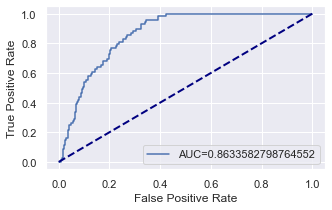

In [65]:
## y_pred_proba = lrm.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [66]:
# A look at model coefficients
print("Coefficients: ",lrm.coef_)
print("intercept: ",lrm.intercept_)

Coefficients:  [[ 0.03622146  1.51080757  0.19242047  0.09216236 -0.11286936  0.10777719
   0.00454349]]
intercept:  [-1.02476112]


In [ ]:
# Looking at the coefficients, age, hypertension,average glucose level, and bmi appear important features
# Before concluding, let's build the model using SVM

In [83]:
from sklearn.svm import SVC
svm = SVC(class_weight='balanced')
svm.fit(X_scaled, y_train)
cv = cross_val_score(svm,X_scaled,y_train,cv=10)
print('svm mean :',cv.mean())

svm mean : 0.7408501948265339


In [84]:
print(metrics.confusion_matrix(svm.predict(X_test_scaled), y_test))

[[1093   16]
 [ 371   53]]


In [85]:
y_pred = svm.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1464
           1       0.12      0.77      0.22        69

    accuracy                           0.75      1533
   macro avg       0.56      0.76      0.53      1533
weighted avg       0.95      0.75      0.82      1533



In [ ]:
#The SVM performance is similar to the logistic regression performance